多因子期货

日线预测涨跌

In [1]:
import os
import sys
import glob
import pathlib
from copy import deepcopy
from itertools import combinations
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import talib
from sklearn import preprocessing

In [2]:
""" 候选品种
TA0 czce    PTA连续
MA0	czce	甲醇连续
RM0	czce	菜粕连续
C0  dce     玉米连续
"""

dfs = {}
symbols = []
future_list = glob.glob("D:/quant/data/futures/*")
future_list = sorted(future_list, key = lambda x: pathlib.Path(x).name[:-4].split(".")[-1])
for i in future_list:
    symbol = pathlib.Path(i).name[:-4]
    # if symbol == "AU0.shfe":
    df = pd.read_csv(i)
    if df.shape[0] > 100:
        dfs[symbol] = df
        symbols.append(symbol)
    # break

In [3]:
rm_df = dfs["RM0.czce"]
ta_df = dfs["TA0.czce"]

rm_df.shape, ta_df.shape

((2325, 6), (3050, 6))

In [4]:
ta_df.head()

,datetime,open,high,low,close,volume
0,2010-01-04,8234,8452,8202,8344,721522
1,2010-01-05,8396,8464,8352,8372,638568
2,2010-01-06,8346,8446,8346,8352,526364
3,2010-01-07,8400,8486,8064,8190,632922
4,2010-01-08,8200,8220,8066,8146,533380


## feature

In [613]:
FUTURE = 3
TASK = "clf"

def get_ma_feature(df):
    periods = np.arange(2,25)
    for i in periods:
        df[f"ma{i}"] = talib.SMA(df["close"], timeperiod=i)
        df[f"ema{i}"] = talib.EMA(df["close"], timeperiod=i)
        df[f"kama{i}"] = talib.KAMA(df["close"], timeperiod=i)
        # df[f"open_ma{i}"] = talib.EMA(df["open"], timeperiod=i)
        
    combines = combinations(periods, 2)
    for i in combines:
        if i[0] < i[1]:
            df[f"ma{i[0]}-{i[1]}"] = df[f"ma{i[0]}"] - df[f"ma{i[1]}"]
        
    return df

def get_add_feature(df):
    low, high, close = df["low"], df["high"], df["close"]
    
    # Bollinger Bands 
    upperband, middleband, lowerband = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df["upperband"], df["middleband"], df["lowerband"] = upperband, middleband, lowerband
    
    # SAR
    SAR = talib.SAR(high, low, acceleration=0, maximum=0)
    df["sar"] = SAR
    
    # Support and resistance
    for i in [5,10,15,30]:
        df[f"support_{i}"] = df["close"].rolling(window=i).min()
        df[f"resistance_{i}"] = df["close"].rolling(window=i).max()

def get_momentum_feature(df):
    low, high, close = df["low"], df["high"], df["close"]
    
    # ADX
    adx = talib.ADX(high, low, close, timeperiod=14)
    df["adx"] = adx
    
    # AROON
    aroondown, aroonup = talib.AROON(high, low, timeperiod=14)
    df["aroondown"], df["aroonup"] = aroondown, aroonup
    
    # CCI
    cci = talib.CCI(high, low, close, timeperiod=14)
    df["cci"] = cci
    
    # MACD
    macd, macdsignal, macdhist = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    df["macd"], df["macdsignal"], df["macdhist"] = macd, macdsignal, macdhist
    
    # MOM
    mom = talib.MOM(close, timeperiod=10)
    df["mom"] = mom
    
    # ROC
    roc = talib.ROC(close, timeperiod=10)
    df["roc"] = roc
    
    # RSI
    rsi = talib.RSI(close, timeperiod=14)
    df["rsi"] = rsi
    
    # KD
    slowk, slowd = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df["slowk"], df["slowd"] = slowk, slowd
    
    # WILLR
    willr = talib.WILLR(high, low, close, timeperiod=14)
    df["willr"] = willr

def get_volume_feature(df):
    low, high, close, volume = df["low"], df["high"], df["close"], df["volume"]
    
    # AD
    ad = talib.AD(high, low, close, volume)
    df["ad"] = ad
    
    # ADOSC
    adsoc = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    df["adsoc"] = adsoc
    
    # OBV
    obv = talib.OBV(close, volume)
    df["obv"] = obv

def get_volatility_feature(df):
    low, high, close = df["low"], df["high"], df["close"]
    
    # ATR
    atr = talib.ATR(high, low, close, timeperiod=14)
    df["atr"] = atr
    
    # TRANGE
    trange = talib.TRANGE(high, low, close)
    df["trange"] = trange

def get_change(df, base="open"):
    gap = FUTURE
    base_change = df.loc[gap:,base].values - df.loc[:(df.shape[0]-1-gap),base].values
    base_change_rate = base_change / df.loc[:(df.shape[0]-1-gap),base].values*100
    return np.hstack([[0]*gap, base_change_rate])


def get_feature_df(df):
    df = deepcopy(df)
    
    close_change = get_change(df, base="close")
    close_open_rate = (df["close"] - df["open"]) / df["open"] * 100
        
    assert TASK in ("clf","reg")
    # calculate up/down
    if TASK=="clf":
        # labels = []
        # for cc,co in zip(np.hstack([close_change[1:], [0]]),
        #                  np.hstack([close_open_rate[1:], [0]])):
        #     if cc > 0 and co > 0:
        #         label = 1 # buy
        #     elif cc < 0 and co < 0:
        #         label = 0 # short
        #     else:
        #         label = 2 # no change
        #     labels.append(label)
        # df["label"] = np.array(labels)
        labels = np.hstack([close_change[1:], [0]*1])
        df["label"] = np.array(list(map(lambda x:1 if x>0 else 0, labels)))
    if TASK=="reg":
        df["label"] = np.hstack([close_open_rate[1:], [0]])
    
    # calculate factor
    df = pd.concat([get_ma_feature(df), get_add_feature(df),
                    get_momentum_feature(df),
                    get_volume_feature(df), get_volatility_feature(df)
                   ])
    
    # drop anomaly value
    df = df.dropna().reset_index(drop=True)
    df = df.drop(0, axis=0).reset_index(drop=True)
    df = df.drop([len(df)-1], axis=0).reset_index(drop=True)
    return df

def get_feature_label(df):
    feature_df = df.drop(["datetime","label"],axis=1)
    # feature_df = (feature_df-feature_df.min())/(feature_df.max()-feature_df.min())
    # feature_df = (feature_df-feature_df.mean())/(feature_df.std())
    features = feature_df.values
    labels = df["label"].values
    return features, labels

In [614]:
get_feature_df(ta_df).head()

,datetime,open,high,low,close,volume,label,ma2,ema2,kama2,...,roc,rsi,slowk,slowd,willr,ad,adsoc,obv,atr,trange
0,2010-02-26,8402,8440,8360,8408,258660,0,8391.0,8407.859885,8419.720262,...,4.447205,56.483847,35.653388,51.732122,-33.333333,1.195064e+06,91063.119177,1566918.0,154.210767,80.0
1,2010-03-01,8494,8500,8342,8358,289348,0,8383.0,8374.619962,8417.738007,...,4.136556,53.677096,17.129034,34.991092,-40.277778,9.643185e+05,-14564.235475,1277570.0,154.481426,158.0
2,2010-03-02,8336,8336,8240,8266,344546,0,8312.0,8302.206654,8350.298893,...,1.522967,48.865546,10.632855,21.138426,-53.055556,8.064016e+05,-106697.696275,933024.0,151.875610,118.0
3,2010-03-03,8294,8334,8244,8258,388762,0,8262.0,8272.735551,8309.277163,...,0.781059,48.458771,6.929151,11.563680,-54.166667,5.385878e+05,-219902.355830,544262.0,147.455924,90.0
4,2010-03-04,8258,8296,8162,8182,361524,0,8220.0,8212.245184,8252.709535,...,-1.040155,44.655674,6.499136,8.020381,-69.139466,2.849814e+05,-326915.171318,182738.0,146.494786,134.0


## analyse

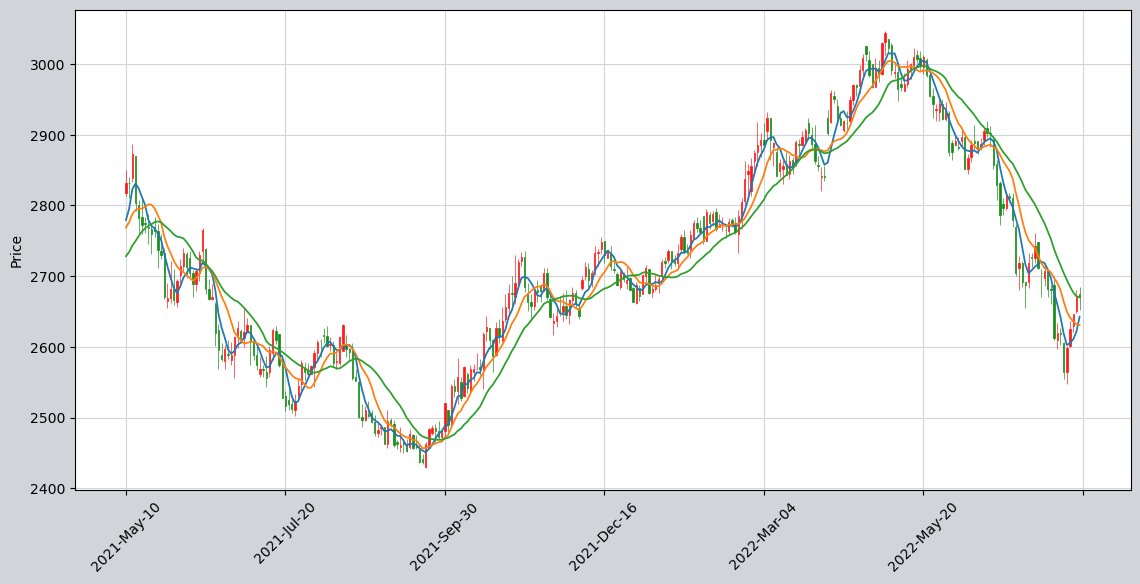

In [510]:
"""
https://blog.csdn.net/Shepherdppz/article/details/117575286
"""
import mplfinance as mpf
def plot_candle(df):
    df = deepcopy(df)
    # 设置mplfinance的蜡烛颜色，up为阳线颜色，down为阴线颜色
    my_color = mpf.make_marketcolors(up='r',
                                     down='g',
                                     edge='inherit',
                                     wick='inherit',
                                     volume='inherit')
    # 设置图表的背景色
    my_style = mpf.make_mpf_style(marketcolors=my_color,
                                  figcolor='(0.82, 0.83, 0.85)',
                                  gridcolor='(0.82, 0.83, 0.85)')


    fig = mpf.figure(style=my_style, figsize=(12, 8), facecolor=(0.82, 0.83, 0.85))
    # 添加三个图表，四个数字分别代表图表左下角在figure中的坐标，以及图表的宽（0.88）、高（0.60）
    ax1 = fig.add_axes([0.06, 0.25, 0.88, 0.60])

    # 读取的测试数据索引为字符串类型，需要转化为时间日期类型
    df.index = pd.to_datetime(df.datetime)

    # 通过ax=ax1参数指定把新的线条添加到ax1中，与K线图重叠
    ap = mpf.make_addplot(df[['ma5', 'ma10', 'ma20']], ax=ax1)
    
    # 调用plot()方法，注意传递addplot=ap参数，以添加均线
    mpf.plot(df,
             ax=ax1,
             addplot=ap,
             type='candle',
             style=my_style)

    fig.show()	
    
analyse = get_feature_df(dfs["C0.dce"])
plot_candle(analyse.iloc[-300:])

## classification

In [634]:
FUTURE = 10
TASK = "clf"

In [635]:
train_X, train_Y, valid_X, valid_Y, test_X, test_Y = [],[],[],[],[],[]

df = dfs["MA0.czce"]
# df = get_feature_df(df)
train_df = df[df["datetime"] < '2021-07-01'].reset_index(drop=True)
valid_df = df[(df["datetime"] > "2021-07-01") & (df["datetime"] < "2022-01-01")].reset_index(drop=True)
test_df = df[df["datetime"] > "2022-01-01"].reset_index(drop=True)

train_data = get_feature_label(get_feature_df(train_df))
valid_data = get_feature_label(get_feature_df(valid_df))
test_data = get_feature_label(get_feature_df(test_df))

print(len(train_data[0]), len(valid_data[0]), len(test_data[0]), train_data[0].shape)

1544 89 104 (1544, 357)


In [617]:
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix, accuracy_score

In [618]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0)
clf.fit(train_data[0], train_data[1])
# clf.predict(valid_data[0]), valid_data[1]

LogisticRegression(random_state=0)

In [619]:
# clf.predict_proba(valid_data[0])

In [620]:
y_true, y_pred = valid_data[1], (clf.predict_proba(valid_data[0])[:,1]+0.5).astype("int") # clf.predict(valid_data[0])
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[32 12]
 [ 3 42]]
              precision    recall  f1-score   support

           0       0.91      0.73      0.81        44
           1       0.78      0.93      0.85        45

    accuracy                           0.83        89
   macro avg       0.85      0.83      0.83        89
weighted avg       0.85      0.83      0.83        89



In [621]:
y_true, y_pred = valid_data[1], (clf.predict_proba(valid_data[0])[:,1]+0.5).astype("int")
accuracy_score(y_true, y_pred)

0.8314606741573034

In [622]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100,max_depth=6, random_state=0)
clf.fit(train_data[0], train_data[1])

RandomForestClassifier(max_depth=6, random_state=0)

In [623]:
# clf.predict_proba(valid_data[0])

In [624]:
y_true, y_pred = valid_data[1], clf.predict(valid_data[0])
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[38  6]
 [ 5 40]]
              precision    recall  f1-score   support

           0       0.88      0.86      0.87        44
           1       0.87      0.89      0.88        45

    accuracy                           0.88        89
   macro avg       0.88      0.88      0.88        89
weighted avg       0.88      0.88      0.88        89



In [625]:
accuracy_score(clf.predict(valid_data[0]), valid_data[1])

0.8764044943820225

In [636]:
import xgboost as xgb

clf = xgb.XGBClassifier()
clf.fit(train_data[0], train_data[1])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [637]:
y_true, y_pred = valid_data[1], clf.predict(valid_data[0])
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))
accuracy_score(clf.predict(valid_data[0]), valid_data[1])

[[41  3]
 [ 3 42]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        44
           1       0.93      0.93      0.93        45

    accuracy                           0.93        89
   macro avg       0.93      0.93      0.93        89
weighted avg       0.93      0.93      0.93        89



0.9325842696629213

In [638]:
import pickle
with open("D:/quant/checkpoint/clf_ma.pickle","wb") as f:
    pickle.dump(clf, f)

## regression

In [450]:
TASK = "reg"

In [451]:
train_X, train_Y, valid_X, valid_Y, test_X, test_Y = [],[],[],[],[],[]

df = dfs["MA0.czce"]
# df = get_feature_df(df)
train_df = df[df["datetime"] < '2021-07-01'].reset_index(drop=True)
valid_df = df[(df["datetime"] > "2021-07-01") & (df["datetime"] < "2022-01-01")].reset_index(drop=True)
test_df = df[df["datetime"] > "2022-01-01"].reset_index(drop=True)

train_data = get_feature_label(get_feature_df(train_df))
valid_data = get_feature_label(get_feature_df(valid_df))
test_data = get_feature_label(get_feature_df(test_df))

print(len(train_data[0]), len(valid_data[0]), len(test_data[0]), train_data[0].shape)

1544 89 104 (1544, 57)


In [452]:
from sklearn.metrics import mean_squared_error

In [453]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(train_data[0], train_data[1])
reg.predict(valid_data[0])
mean_squared_error(valid_data[1], reg.predict(valid_data[0]))

64.91751462398756

In [454]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(max_depth=6, random_state=0)
rf_reg.fit(train_data[0], train_data[1])
rf_reg.predict(valid_data[0])
mean_squared_error(valid_data[1], rf_reg.predict(valid_data[0]))

7.890115664766683

## plot

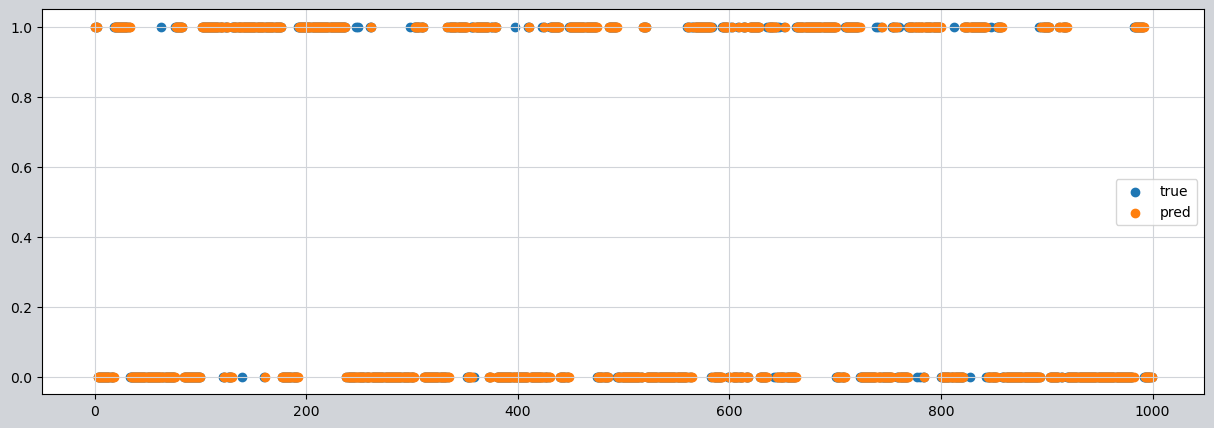

0.076


In [352]:
import matplotlib.pyplot as plt

def evaluate(model, data, label):
    fig = plt.figure(figsize = (15,5))
    # plt.plot(label, label="true")
    plt.scatter(range(len(label)), label, label="true")
    preds = model.predict(data)
    # plt.plot(preds, label="pred")
    plt.scatter(range(len(preds)), preds, label="pred")
    plt.legend()
    plt.show()
    
    print(np.mean((preds - label)**2))

evaluate(clf, train_data[0][:1000], train_data[1][:1000])

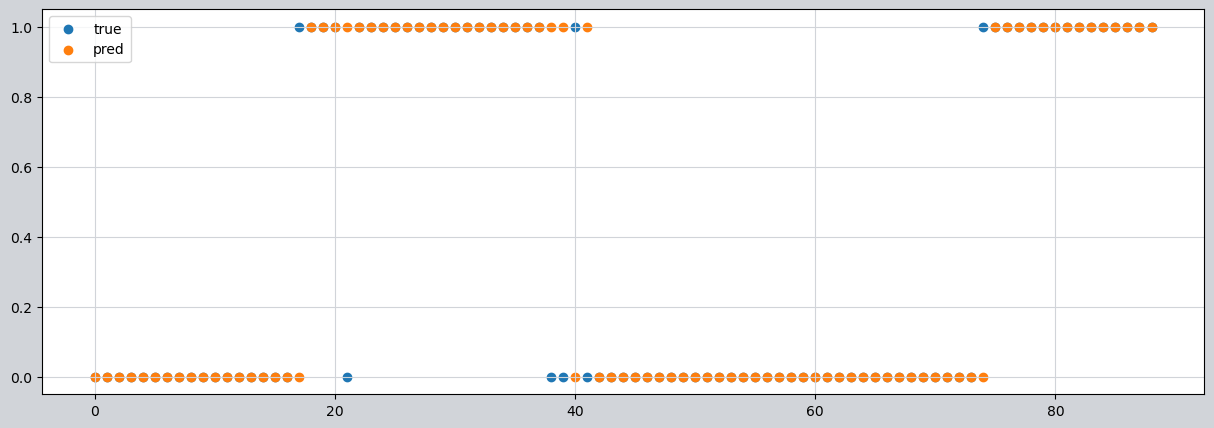

0.07865168539325842


In [353]:
evaluate(clf, valid_data[0], valid_data[1])

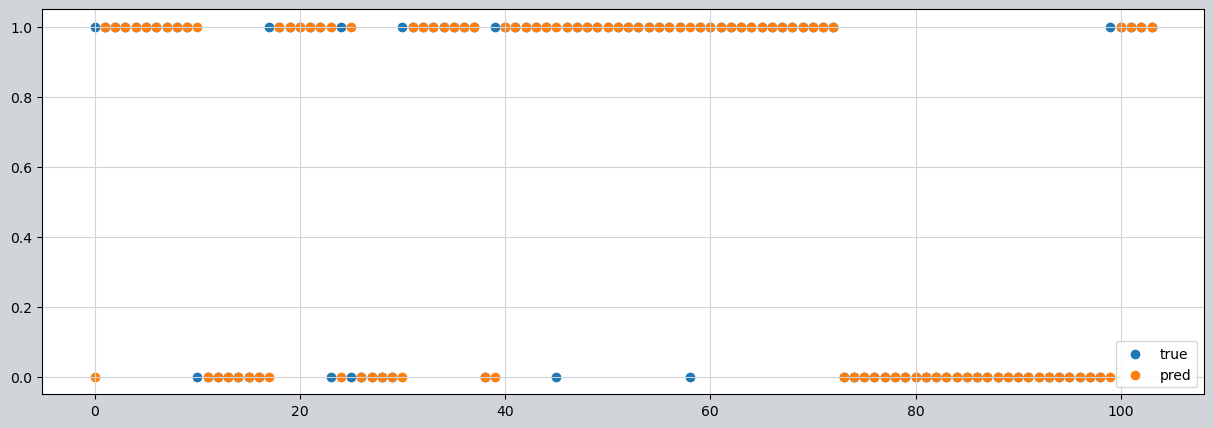

0.10576923076923077


In [354]:
evaluate(clf, test_data[0], test_data[1])